# Fit Series function 

In [3]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [4]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))


def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct


def residuals_func(coefs,x,fi):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns an array with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    residuals = fi - model_function(
        x,
        coefs
    )
    return residuals


def residuals_func_sum_sqr(coefs):
    """Calculate the sum of the squared residuals."""
    result = 0
    num_el = len(x_data)
    for index in range(num_el):
        result = result + residuals_func(coefs,x_data[index],y_data[index])**2
    return result

## Read files

In [5]:
data_path = Path("../../data/regular/finite-size/").resolve()
file = 'finite_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [6]:
df_all_tc = df_all_tc.drop([0,0,0])
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
1,0.333333,0.474172,0.479616,0.485186,0.495462,0.505744,0.516007,0.525276,0.534884,0.543836,0.552571,0.560976,0.569244
2,0.250000,0.406877,0.414960,0.423065,0.438941,0.454636,0.469980,0.484784,0.499695,0.514192,0.528122,0.541821,0.555194
3,0.200000,0.363846,0.373370,0.382903,0.401845,0.420934,0.439931,0.458557,0.476878,0.495042,0.512840,0.530448,0.547399
4,0.166667,0.333171,0.343745,0.354152,0.375527,0.396667,0.418225,0.439601,0.460725,0.481590,0.502270,0.522727,0.542827
5,0.142857,0.310034,0.321274,0.332413,0.355228,0.378443,0.401569,0.424909,0.448019,0.471496,0.494206,0.517180,0.539323
6,0.125000,0.291782,0.303439,0.315214,0.339160,0.363620,0.388241,0.413201,0.438283,0.463279,0.488020,0.512904,0.537341
7,0.111111,0.276996,0.289043,0.301251,0.326111,0.351386,0.377466,0.403509,0.430223,0.456767,0.483182,0.509838,0.535864
8,0.100000,0.264710,0.276865,0.289472,0.315044,0.341337,0.368199,0.395594,0.423065,0.451129,0.479223,0.507185,0.534884
9,0.090909,0.254111,0.266597,0.279344,0.305565,0.332500,0.360230,0.388600,0.417391,0.446461,0.475525,0.504973,0.534120
10,0.083333,0.245040,0.257703,0.270612,0.297316,0.324907,0.353301,0.382481,0.412221,0.442279,0.472541,0.502984,0.533616


In [7]:
df_params = pd.DataFrame(index=["a1","a2"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

1.0
      fun: 0.0029892915831078357
 hess_inv: array([[  8.61329329, -64.73116945],
       [-64.73116945, 492.05137255]])
      jac: array([4.50908556e-06, 5.50353434e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([0.48349498, 2.41064878])
Best fit parameters: [0.48349498 2.41064878]


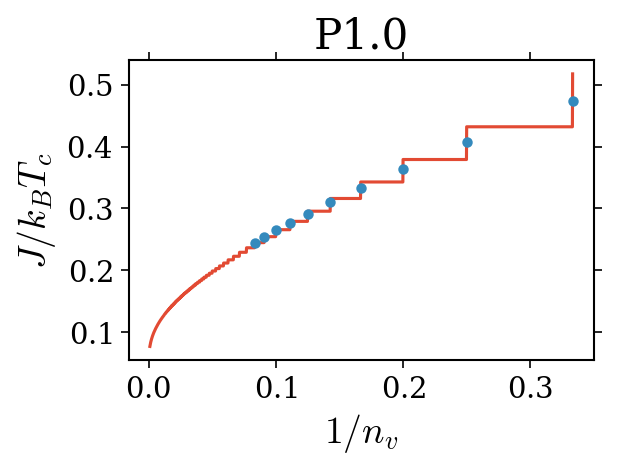

---------------------------------------------
coefs:[0.48349498 2.41064878]
---------------------------------------------
min:0.0773432095987093 at 0.001
fit at 1/nv=1: 1.1655365910789037


1.05
      fun: 0.002758575171964458
 hess_inv: array([[  8.76030451, -58.0749815 ],
       [-58.0749815 , 389.59300182]])
      jac: array([-2.23517418e-08, -6.54836185e-09])
  message: 'Optimization terminated successfully.'
     nfev: 69
      nit: 16
     njev: 23
   status: 0
  success: True
        x: array([0.48722294, 2.25290728])
Best fit parameters: [0.48722294 2.25290728]


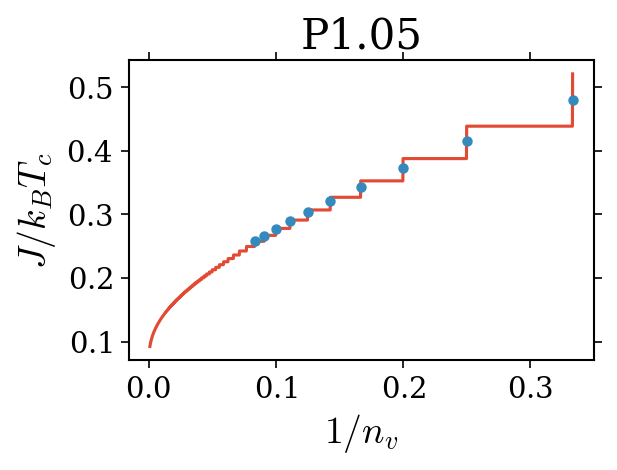

---------------------------------------------
coefs:[0.48722294 2.25290728]
---------------------------------------------
min:0.09235196621142021 at 0.001
fit at 1/nv=1: 1.1431631341311084


1.1
      fun: 0.0025511203983079305
 hess_inv: array([[  8.54762141, -49.89802385],
       [-49.89802385, 294.81580013]])
      jac: array([-8.40486609e-06, -4.52078530e-06])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 16
     njev: 21
   status: 0
  success: True
        x: array([0.49105087, 2.11821544])
Best fit parameters: [0.49105087 2.11821544]


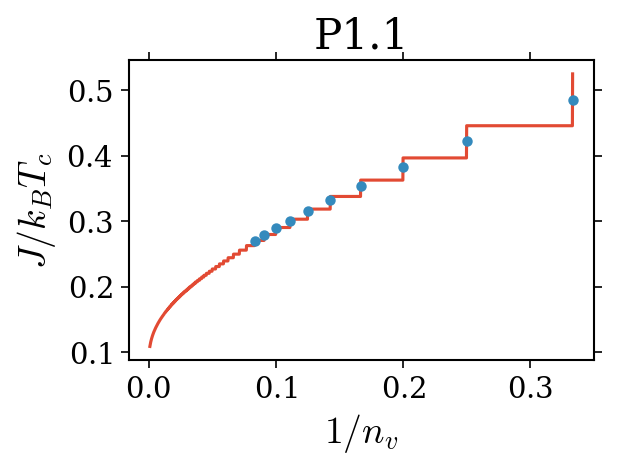

---------------------------------------------
coefs:[0.49105087 2.11821544]
---------------------------------------------
min:0.1090410965832788 at 0.001
fit at 1/nv=1: 1.1212272135859676


1.2
      fun: 0.002108445365670485
 hess_inv: array([[ 10.07427798, -47.5034943 ],
       [-47.5034943 , 226.08676616]])
      jac: array([-7.57019734e-07, -1.23633072e-07])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 16
     njev: 21
   status: 0
  success: True
        x: array([0.50160688, 1.88942982])
Best fit parameters: [0.50160688 1.88942982]


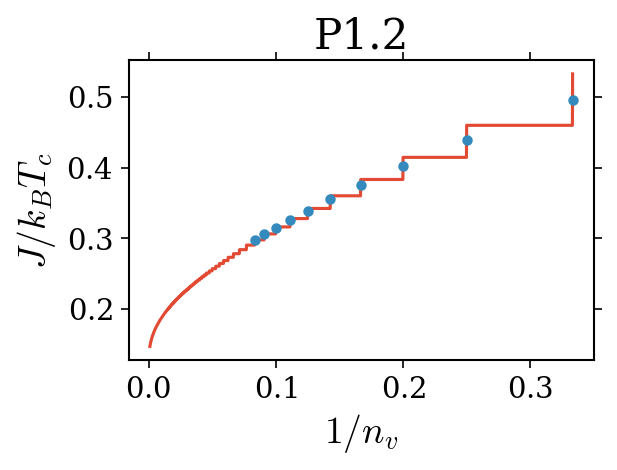

---------------------------------------------
coefs:[0.50160688 1.88942982]
---------------------------------------------
min:0.1473621042828461 at 0.001
fit at 1/nv=1: 1.076367062517421


1.3
      fun: 0.001714383549911014
 hess_inv: array([[ 10.78614638, -40.76188646],
       [-40.76188646, 155.35031341]])
      jac: array([-5.18654997e-06, -1.29056571e-06])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([0.51528362, 1.70789218])
Best fit parameters: [0.51528362 1.70789218]


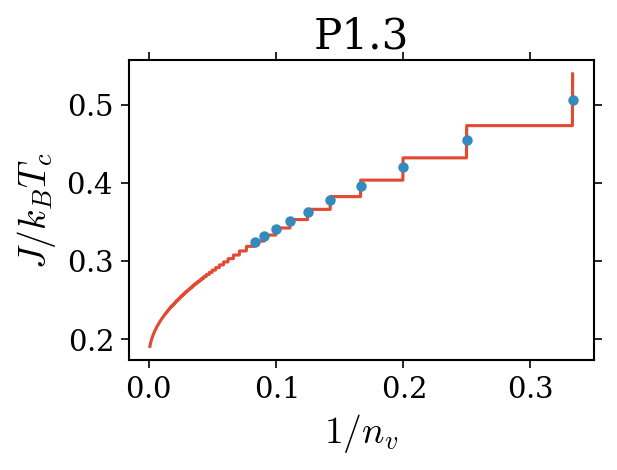

---------------------------------------------
coefs:[0.51528362 1.70789218]
---------------------------------------------
min:0.19090759729596143 at 0.001
fit at 1/nv=1: 1.0333440065550725


1.4
      fun: 0.001380404647745736
 hess_inv: array([[ 12.59156687, -38.27358518],
       [-38.27358518, 117.10565208]])
      jac: array([2.08476558e-06, 6.40866347e-07])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([0.53539987, 1.55223037])
Best fit parameters: [0.53539987 1.55223037]


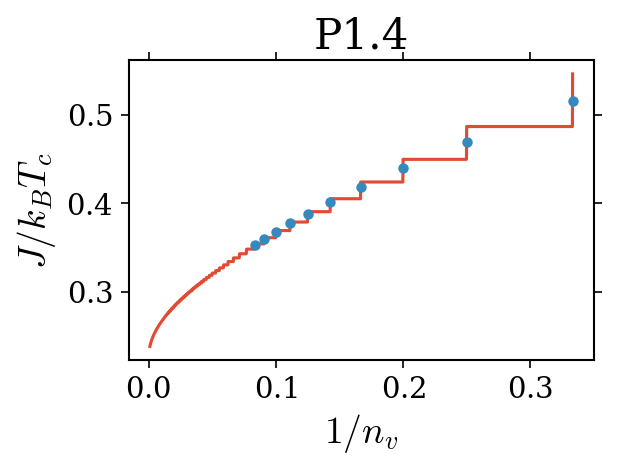

---------------------------------------------
coefs:[0.53539987 1.55223037]
---------------------------------------------
min:0.2381675333640326 at 0.001
fit at 1/nv=1: 0.990870512856894


1.5
      fun: 0.001054378928085915
 hess_inv: array([[ 17.6177947 , -41.73940015],
       [-41.73940015,  99.38188225]])
      jac: array([-1.17182208e-06, -4.70361556e-07])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 22
     njev: 28
   status: 0
  success: True
        x: array([0.56843558, 1.40396259])
Best fit parameters: [0.56843558 1.40396259]


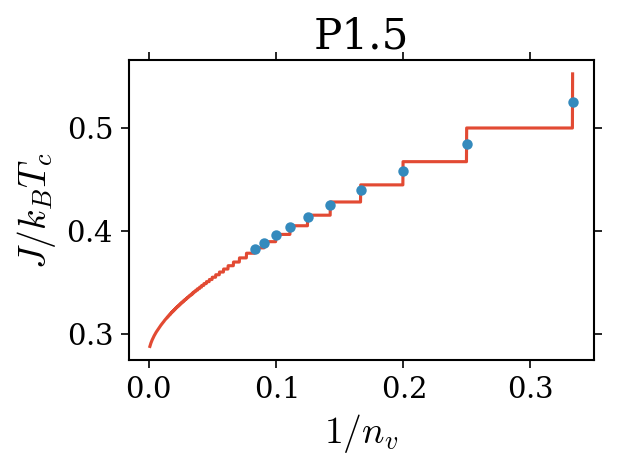

---------------------------------------------
coefs:[0.56843558 1.40396259]
---------------------------------------------
min:0.28772581473638703 at 0.001
fit at 1/nv=1: 0.9456154517798585


1.6
      fun: 0.0008013315758427749
 hess_inv: array([[ 24.87274255, -45.04324829],
       [-45.04324829,  81.87193303]])
      jac: array([-2.58078217e-08, -1.63927325e-08])
  message: 'Optimization terminated successfully.'
     nfev: 99
      nit: 29
     njev: 33
   status: 0
  success: True
        x: array([0.61592925, 1.26898889])
Best fit parameters: [0.61592925 1.26898889]


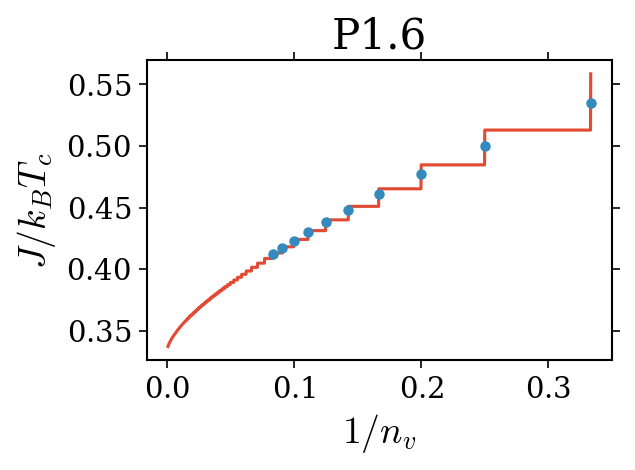

---------------------------------------------
coefs:[0.61592925 1.26898889]
---------------------------------------------
min:0.3372601338965175 at 0.001
fit at 1/nv=1: 0.9017026411366847


1.7
      fun: 0.0005688143031331664
 hess_inv: array([[ 45.6419715 , -59.76240141],
       [-59.76240141,  78.43282473]])
      jac: array([-5.82913344e-07, -3.46044544e-07])
  message: 'Optimization terminated successfully.'
     nfev: 78
      nit: 21
     njev: 26
   status: 0
  success: True
        x: array([0.69320919, 1.1316278 ])
Best fit parameters: [0.69320919 1.1316278 ]


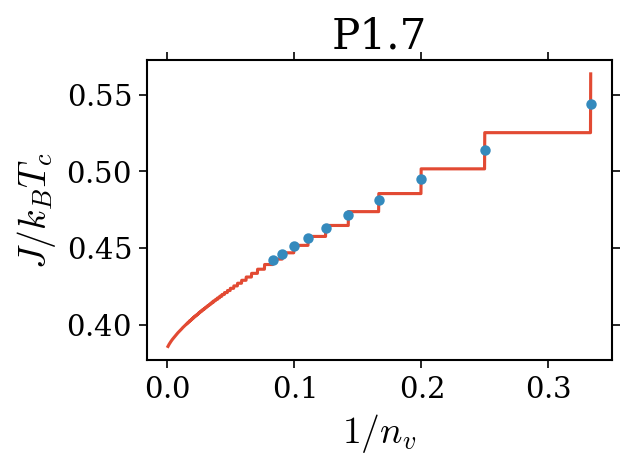

---------------------------------------------
coefs:[0.69320919 1.1316278 ]
---------------------------------------------
min:0.3859893486609372 at 0.001
fit at 1/nv=1: 0.8553826641045258


1.8
      fun: 0.00038982610695837186
 hess_inv: array([[ 94.02399053, -82.71188274],
       [-82.71188274,  72.87878423]])
      jac: array([-1.12351699e-07, -1.12147973e-07])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 28
   status: 0
  success: True
        x: array([0.8231192 , 0.98890461])
Best fit parameters: [0.8231192  0.98890461]


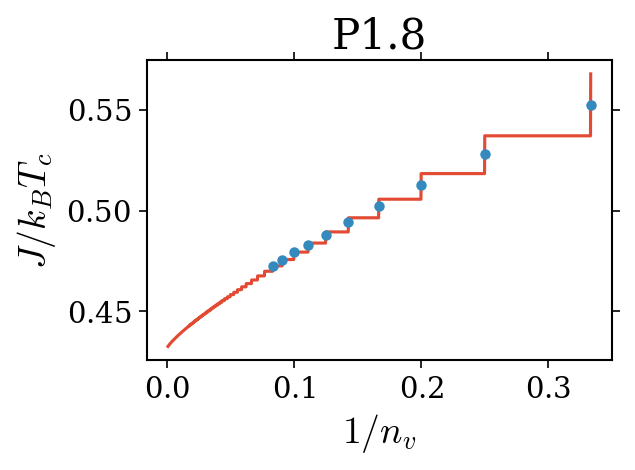

---------------------------------------------
coefs:[0.8231192  0.98890461]
---------------------------------------------
min:0.43265006474428147 at 0.001
fit at 1/nv=1: 0.8067531160669674


1.9
      fun: 0.0002466034636169925
 hess_inv: array([[ 253.81630212, -129.46105902],
       [-129.46105902,   66.08828404]])
      jac: array([-2.10536746e-06, -1.22250640e-06])
  message: 'Optimization terminated successfully.'
     nfev: 114
      nit: 28
     njev: 38
   status: 0
  success: True
        x: array([1.0769071 , 0.82881626])
Best fit parameters: [1.0769071  0.82881626]


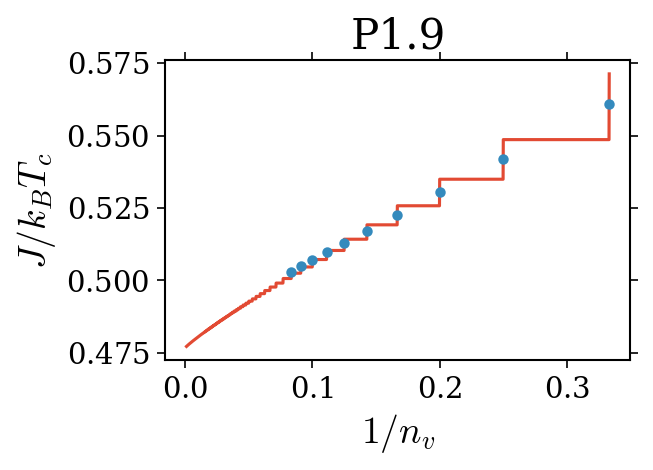

---------------------------------------------
coefs:[1.0769071  0.82881626]
---------------------------------------------
min:0.4771852882831919 at 0.001
fit at 1/nv=1: 0.753787520259208


2.0
      fun: 0.00015178682971540435
 hess_inv: array([[1798.75055968, -400.9594252 ],
       [-400.9594252 ,   89.40456377]])
      jac: array([-1.91635263e-06, -8.45112845e-06])
  message: 'Optimization terminated successfully.'
     nfev: 183
      nit: 49
     njev: 61
   status: 0
  success: True
        x: array([1.69697393, 0.63999031])
Best fit parameters: [1.69697393 0.63999031]


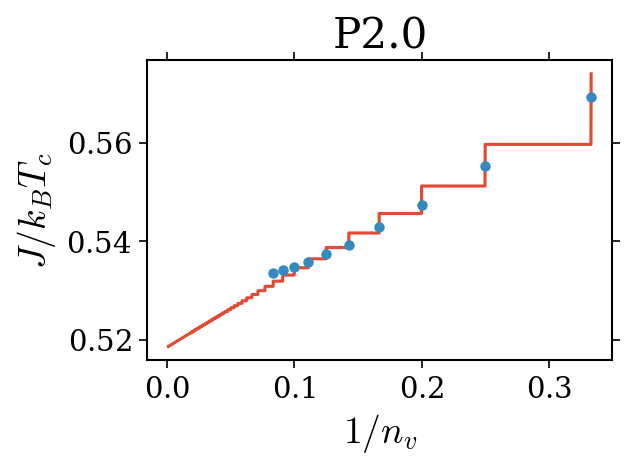

---------------------------------------------
coefs:[1.69697393 0.63999031]
---------------------------------------------
min:0.5186924590711809 at 0.001
fit at 1/nv=1: 0.6950594639543464




In [8]:
epsilon = 0.0001
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
# COLUMNS = ["P1.05"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus'
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    print(p)
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
#     # add value at nv=1
#     x_data = np.concatenate([x_data,[1]])
#     y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)
        
    # fit 
    best_fit_result = minimize(residuals_func_sum_sqr,
                               x0=(1,1.5),
                              )
    print(best_fit_result)
    best_fit_coefs = best_fit_result.x
    print("Best fit parameters:", best_fit_coefs)

#     (a1,a2) = best_fit_coefs 
    df_params[COLUMN] = best_fit_coefs
    extrapol_funct = get_extrapol_function(model_function, best_fit_coefs)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1/3, 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
#     ax.text(0.1, 0.2, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$",
#            fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_coefs))
    print("---------------------------------------------")
    df_extrapol_val[COLUMN] = [extrapol_funct(0+epsilon),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")

In [12]:
1/df_extrapol_val

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,inf,39.886041,19.375626,9.289150,6.052231,4.493221,3.586743,3.007937,2.607107,2.317380,2.097680,1.928514
1,0.857974,0.874766,0.891880,0.929051,0.967732,1.009214,1.057512,1.109013,1.169067,1.239537,1.326634,1.438726


In [10]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
# COLUMNS = ["P1.05"]

for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [13]:
file_name_base

'finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus'

In [14]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves_nv-12.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values_nv-12.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0     P1.05      P1.1      P1.2      P1.3     P1.4      P1.5  \
a1  0.483495  0.487223  0.491051  0.501607  0.515284  0.53540  0.568436   
a2  2.410649  2.252907  2.118215  1.889430  1.707892  1.55223  1.403963   

        P1.6      P1.7      P1.8      P1.9      P2.0  
a1  0.615929  0.693209  0.823119  1.076907  1.696974  
a2  1.268989  1.131628  0.988905  0.828816  0.639990  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\Extrapolation\finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus_params_curves_nv-12.csv
           P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
infty  0.000000  0.025071  0.051611  0.107652  0.165228  0.222557  0.278804   
1      1.165537  1.143163  1.121227  1.076367  1.033344  0.990871  0.945615   

           P1.6      P1.7      P1.8      P1.9      P2.0  
infty  0.332454  0.383567  0.431522  0.476717  0.518534  
1      0.901703 

## Plot extrapol values

c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


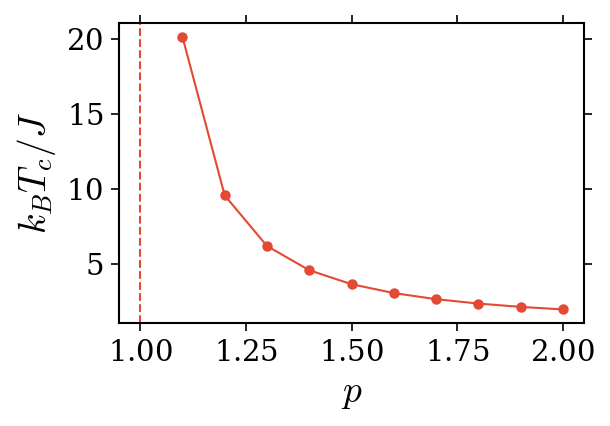

In [32]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = df_extrapol_val.columns.map(lambda x: float(x.replace('P',''))).values
x_data = np.delete(x_data,1) # clear 1.05
y_data = 1/df_extrapol_val.loc['infty'].values
y_data = np.delete(y_data,1) # clear 1.05
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()